# Recommender Playlists

Recommend songs based on track features and current playlists using ML.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# To create a playlist and add tracks
import spotipy 
from spotipy.oauth2 import SpotifyOAuth

## Import Data

- Artist and track data was pulled using the Spotify API via the spotipy package
- Data was saved in pickle format using music_data.py and data_functions.py modules
- The data can now be quickly read by multiple workflows

In [5]:
top_artist_df = pd.read_pickle("spotify/top_artists.pkl")
followed_artists_df = pd.read_pickle("spotify/followed_artists.pkl")
top_tracks_df = pd.read_pickle("spotify/top_tracks.pkl")
saved_tracks_df = pd.read_pickle("spotify/saved_tracks.pkl")
playlist_tracks_df = pd.read_pickle("spotify/playlist_tracks.pkl")
recommendation_tracks_df = pd.read_pickle("spotify/recommendation_tracks.pkl")

In [6]:
# Remove duplicates on track id
playlist_tracks_df = playlist_tracks_df.drop_duplicates(subset='id', keep="first").reset_index()
recommendation_tracks_df = recommendation_tracks_df.drop_duplicates(subset='id', keep="first").reset_index()
# Avoid data leakage
recommendation_tracks_df = recommendation_tracks_df[~recommendation_tracks_df['id'].isin(playlist_tracks_df['id'].tolist())]

In [7]:
playlist_tracks_df.head()

,index,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature
0,0,6fgbQt13JlpN59PytgTMsA,Snow (Hey Oh),61,audio_features,False,False,334667,1,1,...,0.0499,0.116000,0.000017,0.119,0.599,104.655,spotify:track:6fgbQt13JlpN59PytgTMsA,https://api.spotify.com/v1/tracks/6fgbQt13JlpN...,https://api.spotify.com/v1/audio-analysis/6fgb...,4
1,1,3JOdLCIBzQYwHIvpN3isVf,Grand Theft Autumn / Where Is Your Boy,62,audio_features,False,False,191373,1,3,...,0.0608,0.000706,0.000000,0.275,0.720,135.450,spotify:track:3JOdLCIBzQYwHIvpN3isVf,https://api.spotify.com/v1/tracks/3JOdLCIBzQYw...,https://api.spotify.com/v1/audio-analysis/3JOd...,4
2,2,7pAT4dOUzjq8Ziap5ShIqC,Where'd You Go (feat. Holly Brook & Jonah Matr...,58,audio_features,False,True,231867,1,6,...,0.2380,0.262000,0.001970,0.113,0.250,179.999,spotify:track:7pAT4dOUzjq8Ziap5ShIqC,https://api.spotify.com/v1/tracks/7pAT4dOUzjq8...,https://api.spotify.com/v1/audio-analysis/7pAT...,4
3,3,1b7vg5T9YKR3NNqXfBYRF7,Check Yes Juliet,53,audio_features,False,False,220133,1,3,...,0.0774,0.002400,0.000000,0.163,0.314,166.866,spotify:track:1b7vg5T9YKR3NNqXfBYRF7,https://api.spotify.com/v1/tracks/1b7vg5T9YKR3...,https://api.spotify.com/v1/audio-analysis/1b7v...,4
4,4,12qZHAeOyTf93YAWvGDTat,All The Small Things,0,audio_features,False,False,168000,1,8,...,0.0505,0.008440,0.000000,0.529,0.712,148.119,spotify:track:12qZHAeOyTf93YAWvGDTat,https://api.spotify.com/v1/tracks/12qZHAeOyTf9...,https://api.spotify.com/v1/audio-analysis/12qZ...,4


## Create Ratings

I want to avoid time labelling my data, the best way to form recommendations would be to rate all my playlist songs from 1-10 and form a regression problem. I'm skipping this as I have some favourite playlists, so can turn this into a classifcation problem.

- Classify tracks in my favourite playlists as 1
- Classify the rest as 0

In [8]:
# Load list of playlist ids for my favourite playlists
with open("spotify/playlists.yml", 'r') as stream:
    playlists = yaml.safe_load(stream)

playlist_tracks_df['ratings'] = playlist_tracks_df['playlist_id'].apply(lambda x: 1 if x in playlists.values() else 0)
playlist_tracks_df['ratings']

0       1
1       1
2       1
3       1
4       1
       ..
2604    0
2605    0
2606    0
2607    0
2608    0
Name: ratings, Length: 2609, dtype: int64

In [9]:
# Training data
X = playlist_tracks_df[['popularity', 'explicit', 'duration_ms', 'danceability', 'energy',
                        'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                        'liveness', 'valence', 'tempo', 'time_signature', 'genres']]  # order here is important for xgboost later
y = playlist_tracks_df['ratings']

# Drop NA
X = X.dropna()
recommendation_tracks_df = recommendation_tracks_df.dropna()

# Create genre columns (one-hot encoding)
X = X.drop('genres', 1).join(X['genres'].str.join('|').str.get_dummies())
X_recommend = recommendation_tracks_df.copy()
X_recommend = X_recommend.drop('genres', 1).join(X_recommend['genres'].str.join('|').str.get_dummies())

# Ensure features are consistent across training, test, and evaluation
X = X[X.columns.intersection(X_recommend.columns)]
X_recommend = X_recommend[X_recommend.columns.intersection(X.columns)]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,popularity,explicit,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,...,urban contemporary,vapor soul,vapor twitch,vegas indie,video game music,viral pop,visual kei,washington indie,welsh metal,wonky
49,81,False,177507,0.505,0.710,3,-3.015,1,0.0321,0.1900,...,0,0,0,0,0,0,0,0,0,0
582,61,False,296560,0.484,0.727,0,-6.107,1,0.0358,0.1980,...,0,0,0,0,0,0,0,0,0,0
2371,18,False,197901,0.580,0.857,0,-3.827,1,0.0666,0.0743,...,0,0,0,0,0,0,0,0,0,0
48,83,False,233720,0.609,0.378,4,-9.828,1,0.4380,0.8350,...,0,0,0,0,0,0,0,0,0,0
1674,47,False,309000,0.582,0.886,2,-5.104,1,0.0434,0.0290,...,0,0,0,0,0,0,0,0,0,0


## ML Time

As this is a POC for fun I won't spend a lot of time optimising the features/model.

- Feature rankings
- No need to PCA we don't assume a linear relationship between variables and we want our components to be interpretable
- ML models for classification (logistic regression, random forest, xgboost, knn)

### Feature Rankings

Fitting estimator with 378 features.
Fitting estimator with 377 features.
Fitting estimator with 376 features.
Fitting estimator with 375 features.
Fitting estimator with 374 features.
Fitting estimator with 373 features.
Fitting estimator with 372 features.
Fitting estimator with 371 features.
Fitting estimator with 370 features.
Fitting estimator with 369 features.
Fitting estimator with 368 features.
Fitting estimator with 367 features.
Fitting estimator with 366 features.
Fitting estimator with 365 features.
Fitting estimator with 364 features.
Optimal number of features: 363


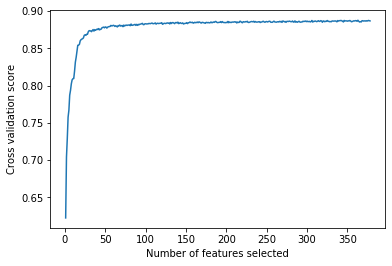

In [10]:
# Cross-validation for number of features
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rfecv = RFECV(estimator=rf, step=1, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
rfecv.fit(X_train, y_train)

print(f'Optimal number of features: {rfecv.n_features_}')

plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score')
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

In [10]:
# Analyze feature importances

# Can use this with previous rfecv to reduce the number of features to speed up model training if needed 
# ~80 in this case
rfc = RandomForestClassifier(n_estimators = 1000, max_depth=4, random_state=42)
rfc.fit(X_train, y_train)

important_features_dict = {}
for idx, val in enumerate(rfc.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

# Print the top 80 features
for i in range(len(important_features_list[:80])):
    print(f"{i+1}. {X_train.columns[important_features_list[i]]} {important_features_dict[important_features_list[i]]}")

1. loudness 0.09026153216724604
2. instrumentalness 0.08175293168393384
3. energy 0.0698657937806919
4. acousticness 0.06927895270869916
5. pop punk 0.051846490782025044
6. popularity 0.04971388232782843
7. edm 0.043101373180974366
8. video game music 0.03786228043374934
9. j-pop 0.032141723366064565
10. pop 0.02650914076131575
11. modern rock 0.02385857376159443
12. electro house 0.023242168307445167
13. punk 0.022780133302881936
14. valence 0.020561437962552113
15. duration_ms 0.019382052052923957
16. future bass 0.01937554754014397
17. rock 0.018825683032217787
18. alternative metal 0.01492230428523666
19. k-pop 0.014451208035697551
20. j-rock 0.011924165211257214
21. pop dance 0.011343989487854115
22. danceability 0.011197068385870068
23. j-poprock 0.009890007693636902
24. dance pop 0.009752739173984983
25. electropop 0.009609402874494875
26. tropical house 0.009471552719492132
27. speechiness 0.008365899788267472
28. time_signature 0.007977071108840593
29. k-pop girl group 0.00793

### Logistic Regression

In [12]:
# Logistic Regression
# Poor model, looks like this isn't a linear problem

# Rescale features from 0 to 1
minmax_scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(minmax_scaler.fit_transform(X_train), columns=X_train.columns)

# Didn't work but not too concerned as this is both a POC for fun and likely a non-linear problem
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       355
           1       0.32      1.00      0.48       167

    accuracy                           0.32       522
   macro avg       0.16      0.50      0.24       522
weighted avg       0.10      0.32      0.16       522



/Users/anthony/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [13]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 1000, random_state=42)
rfc_gcv_parameters = {'min_samples_leaf': [1, 3, 5, 8], 
                      'max_depth': [3, 4, 5, 8, 12, 16, 20], 
                     }
rfe_gcv = GridSearchCV(rfc, rfc_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
rfe_gcv.fit(X_train, y_train)
rfe_gcv.best_estimator_, rfe_gcv.best_score_

Fitting 2 folds for each of 28 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:   26.6s finished


(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=20, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=1000,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 0.885147307517795)

In [14]:
print(classification_report(y_test, rfe_gcv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       355
           1       0.77      0.69      0.73       167

    accuracy                           0.84       522
   macro avg       0.82      0.80      0.80       522
weighted avg       0.83      0.84      0.83       522



### XGBoost

In [39]:
# XGBoost Classifier
xgb = XGBClassifier(n_estimators = 1000, random_state=42, use_label_encoder=False)
xgb_gcv_parameters = {'eta': [0.2, 0.3, 0.4, 0.5],
                      'min_child_weight': [0.3, 0.5, 0.8, 1],
                      'max_depth': [3, 4, 5, 8, 12, 16, 20], 
                     }
xgb_gcv = GridSearchCV(xgb, xgb_gcv_parameters, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
xgb_gcv.fit(X_train, y_train)  # use numpy values as xgboost requres fixed ordering
xgb_gcv.best_estimator_, xgb_gcv.best_score_

Fitting 2 folds for each of 112 candidates, totalling 224 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 224 out of 224 | elapsed: 16.3min finished


[19:54:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
               gpu_id=-1, importance_type='gain', interaction_constraints='',
               learning_rate=0.200000003, max_delta_step=0, max_depth=16,
               min_child_weight=0.3, missing=nan, monotone_constraints='()',
               n_estimators=1000, n_jobs=8, num_parallel_tree=1,
               objective='binary:logistic', random_state=42, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', use_label_encoder=False,
               validate_parameters=1, verbosity=None),
 0.8521265387435846)

In [40]:
print(classification_report(y_test, xgb_gcv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       355
           1       0.70      0.68      0.69       167

    accuracy                           0.80       522
   macro avg       0.78      0.77      0.77       522
weighted avg       0.80      0.80      0.80       522



### KNN

In [41]:
# KNN Classifier
knn = KNeighborsClassifier(n_jobs=-1)
knn_gcv_params = {'n_neighbors': range(1, 10)}

knn_gcv = GridSearchCV(knn, knn_gcv_params, n_jobs=-1, cv=StratifiedKFold(2), verbose=1, scoring='roc_auc')
knn_gcv.fit(X_train, y_train)
knn_gcv.best_params_, knn_gcv.best_score_

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.8s finished


({'n_neighbors': 9}, 0.5363571559180647)

In [42]:
print(classification_report(y_test, knn_gcv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.88      0.77       355
           1       0.34      0.13      0.18       167

    accuracy                           0.64       522
   macro avg       0.51      0.51      0.48       522
weighted avg       0.57      0.64      0.58       522



# Recommendations

- Looks like the random forest and xgboost classifiers perform the best, let's see what they recommend should be in "Best Of"
- Use recommendation_tracks_df as the evaluation dataset

In [43]:
# Predict
recommendation_tracks_df['ratings'] = rfe_gcv.predict(X_recommend)
recommendation_tracks_df['prob_ratings'] = rfe_gcv.predict_proba(X_recommend)[:,1]  # slice for probability of 1
recommendation_tracks_df[recommendation_tracks_df['ratings'] == 1].head()

,index,id,name,popularity,type,is_local,explicit,duration_ms,disc_number,track_number,...,instrumentalness,liveness,valence,tempo,uri,track_href,analysis_url,time_signature,ratings,prob_ratings
1,1,06wTEKL2rSrSaOjFtgG8fj,Slow Cheetah,58,audio_features,False,False,319933.0,1,7,...,0.000141,0.0715,0.244,178.102,spotify:track:06wTEKL2rSrSaOjFtgG8fj,https://api.spotify.com/v1/tracks/06wTEKL2rSrS...,https://api.spotify.com/v1/audio-analysis/06wT...,4.0,1,0.589288
2,2,4Zc7TCHzuNwL0AFBlyLdyr,Run to the Hills - 2015 Remaster,71,audio_features,False,False,233507.0,1,6,...,0.004010,0.1620,0.458,173.671,spotify:track:4Zc7TCHzuNwL0AFBlyLdyr,https://api.spotify.com/v1/tracks/4Zc7TCHzuNwL...,https://api.spotify.com/v1/audio-analysis/4Zc7...,4.0,1,0.571000
3,3,1vcxF91pWs9uNwDROuiCPB,Savior,75,audio_features,False,False,242280.0,1,11,...,0.000142,0.4250,0.478,112.490,spotify:track:1vcxF91pWs9uNwDROuiCPB,https://api.spotify.com/v1/tracks/1vcxF91pWs9u...,https://api.spotify.com/v1/audio-analysis/1vcx...,4.0,1,0.757779
4,4,2oSpQ7QtIKTNFfA08Cy0ku,It's The End Of The World As We Know It (And I...,70,audio_features,False,False,246933.0,1,6,...,0.000000,0.0251,0.797,205.528,spotify:track:2oSpQ7QtIKTNFfA08Cy0ku,https://api.spotify.com/v1/tracks/2oSpQ7QtIKTN...,https://api.spotify.com/v1/audio-analysis/2oSp...,4.0,1,0.582699
5,5,4iG2gAwKXsOcijVaVXzRPW,Time to Pretend,73,audio_features,False,True,261000.0,1,1,...,0.077700,0.3000,0.421,100.990,spotify:track:4iG2gAwKXsOcijVaVXzRPW,https://api.spotify.com/v1/tracks/4iG2gAwKXsOc...,https://api.spotify.com/v1/audio-analysis/4iG2...,3.0,1,0.653742


In [44]:
# 166 tracks where prob_ratings >= 0.8 which is a good number
tracks_to_add = recommendation_tracks_df[recommendation_tracks_df['prob_ratings'] >= 0.8]['id']
len(tracks_to_add)

166

In [45]:
# Spotify API
with open("spotify/spotify_details.yml", 'r') as stream:
    spotify_details = yaml.safe_load(stream)

scope = "playlist-modify-private"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=spotify_details['client_id'],
    client_secret=spotify_details['client_secret'],
    redirect_uri=spotify_details['redirect_uri'],
    scope=scope,
))

# Create a new playlist for tracks to add - you may also add these tracks to your source playlist and proceed
new_playlist = sp.user_playlist_create(user=spotify_details['user'], 
                                       name="spotify-recommender-playlists",
                                       public=False, 
                                       collaborative=False, 
                                       description="Created by https://github.com/anthonyli358/spotify-recommender-systems",
                                      )

# Add tracks to the new playlist
for id in tracks_to_add:
    sp.user_playlist_add_tracks(user=spotify_details['user'], 
                                playlist_id=new_playlist['id'], 
                                tracks=[id],
                               );

This worked very well, both the playlist generated by random forest and the playlist generated by xgboost have a good mix of genres, langauges, and songs. I have some new song recommendations to listen to!